In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

# labels

In [3]:
labels = os.listdir("../input/drowsiness-dataset/train")

In [4]:
labels

['Closed', 'Open', 'yawn', 'no_yawn']

# visualize random 1 image

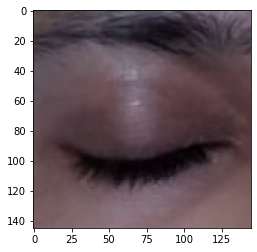

In [5]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Closed/_0.jpg"))

# image array

In [6]:
a = plt.imread("../input/drowsiness-dataset/train/yawn/10.jpg")

# image shape

In [7]:
a.shape

(480, 640, 3)

# visualize yawn image. 
# Here background is unnecessary. we need only face image array

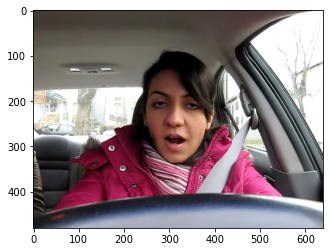

In [8]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/yawn/10.jpg"))

# for yawn and not_yawn. Take only face

In [9]:
def face_for_yawn(direc="../input/drowsiness-dataset/train", face_cas_path="../input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


# for closed and open eye

In [10]:
def get_data(dir_path="../input/drowsiness-dataset/train/", face_cas="../input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../input/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [11]:
data_train = get_data()

2
3


# extend data and convert array

In [12]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

# new variable to store

In [13]:
new_data = append_data()

0
1
2
3


# separate label and features

In [14]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# reshape the array

In [15]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# LabelBinarizer

In [16]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

# label array

In [17]:
y = np.array(y)

# train test split

In [18]:
from sklearn.model_selection import train_test_split
seed = 40
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# length of X_test

In [19]:
len(X_test)

385

# Not necessary, only use to matching with my pc version

In [20]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

# import some dependencies

In [21]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# tensorflow version

In [22]:
tf.__version__

'2.3.0'

# keras version

In [23]:
import keras
keras.__version__

'2.4.3'

# Data Augmentation

In [24]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [25]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

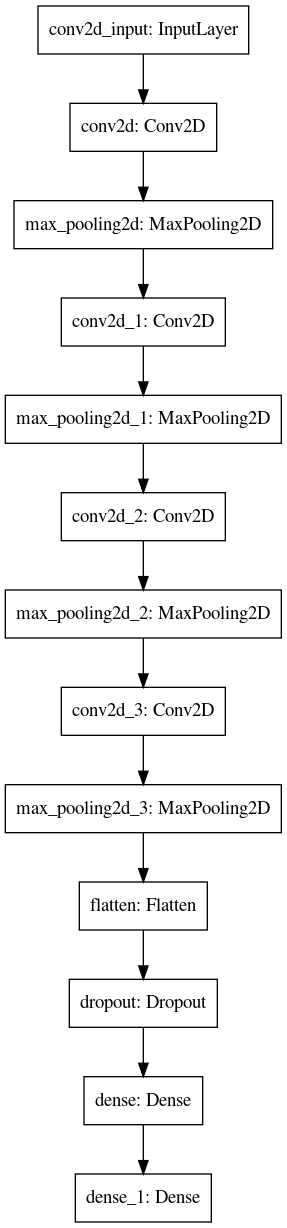

In [46]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='mymodel1.png', show_layer_names=True)
Image(filename='mymodel1.png') 

In [26]:
history = model.fit(train_generator, epochs=30, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/30
49/49 [==============================] - 204s 4s/step - loss: 1.1572 - accuracy: 0.4903 - val_loss: 0.7224 - val_accuracy: 0.7636
Epoch 2/30
49/49 [==============================] - 198s 4s/step - loss: 0.5735 - accuracy: 0.7643 - val_loss: 0.3131 - val_accuracy: 0.8753
Epoch 3/30
49/49 [==============================] - 196s 4s/step - loss: 0.4104 - accuracy: 0.8331 - val_loss: 0.3478 - val_accuracy: 0.8675
Epoch 4/30
49/49 [==============================] - 209s 4s/step - loss: 0.3588 - accuracy: 0.8545 - val_loss: 0.2470 - val_accuracy: 0.9143
Epoch 5/30
49/49 [==============================] - 196s 4s/step - loss: 0.3191 - accuracy: 0.8727 - val_loss: 0.2065 - val_accuracy: 0.9247
Epoch 6/30
49/49 [==============================] - 196s 4s/step - loss: 0.2797 - accuracy: 0.8883 - val_loss: 0.2299 - val_accuracy: 0.9091
Epoch 7/30
49/49 [==============================] - 211s 4s/step - loss: 0.2533 - accuracy: 0.8974 - val_loss: 0.1781 - val_accuracy: 0.9221
Epoch 8/30
49

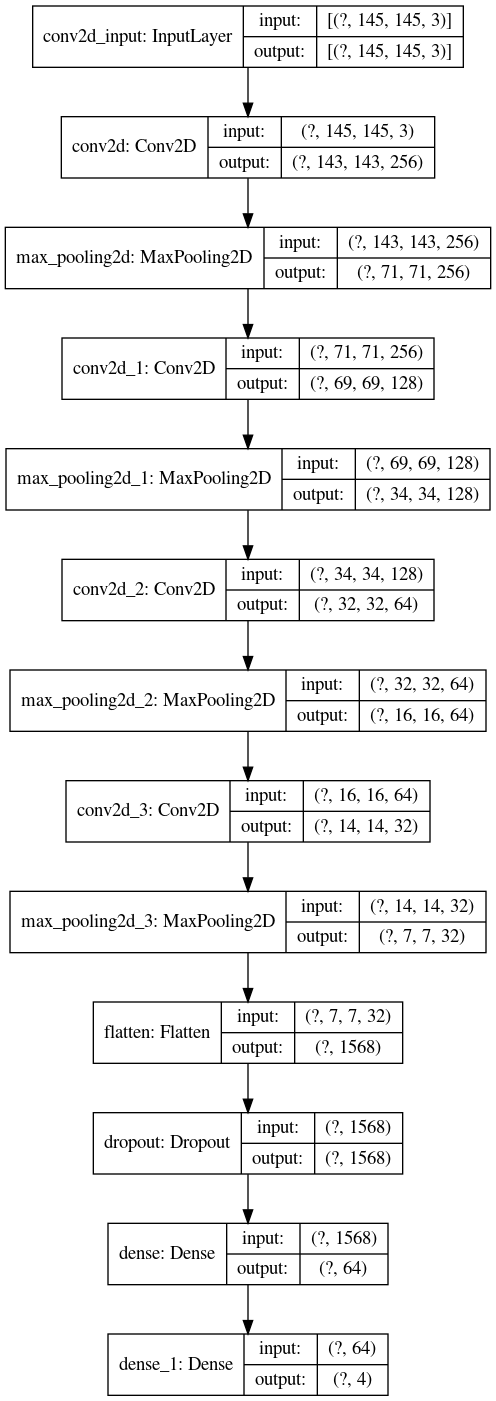

In [42]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='mymodel.png', show_shapes=True,show_layer_names=True)
Image(filename='mymodel.png') 

# history

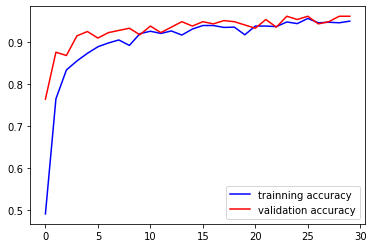

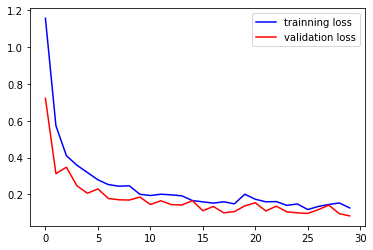

In [27]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [32]:
model.save("drowiness_new_finalmee.h5")

In [31]:
model.save("drowiness_new_final.model")

# Prediction

In [34]:
prediction = model.predict_classes(X_test)

In [35]:
prediction

array([2, 2, 0, 2, 3, 3, 3, 2, 3, 1, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3,
       3, 0, 2, 2, 2, 1, 2, 3, 3, 3, 3, 1, 1, 2, 3, 2, 3, 2, 3, 2, 2, 2,
       3, 3, 1, 2, 2, 0, 2, 3, 3, 3, 3, 3, 2, 1, 2, 2, 1, 2, 2, 3, 2, 1,
       3, 2, 2, 2, 1, 3, 2, 3, 3, 0, 3, 0, 2, 0, 2, 1, 2, 3, 3, 3, 3, 0,
       2, 2, 3, 2, 1, 3, 3, 3, 2, 2, 0, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1,
       3, 1, 2, 3, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 3, 3, 2, 3, 2, 3, 2,
       3, 2, 2, 2, 2, 1, 3, 1, 1, 2, 2, 1, 3, 2, 0, 3, 2, 2, 2, 3, 2, 2,
       2, 3, 0, 2, 2, 1, 2, 3, 0, 1, 2, 3, 3, 2, 2, 3, 0, 2, 2, 3, 3, 1,
       2, 1, 2, 2, 1, 3, 3, 2, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 0, 2, 3,
       0, 0, 3, 3, 1, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 0, 3, 3, 3, 0, 2,
       0, 3, 1, 2, 3, 2, 0, 3, 0, 2, 2, 2, 2, 3, 0, 0, 3, 1, 3, 2, 2, 2,
       2, 3, 0, 3, 3, 3, 2, 3, 1, 0, 3, 1, 3, 3, 0, 2, 2, 3, 3, 1, 0, 2,
       3, 3, 3, 3, 2, 3, 1, 1, 3, 2, 2, 3, 3, 2, 2, 3, 1, 2, 1, 3, 3, 3,
       3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 2, 2, 3, 1, 3,

# classification report

In [36]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [37]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.97      0.74      0.84        43
     no_yawn       0.70      0.98      0.82        41
      Closed       0.98      0.96      0.97       157
        Open       0.97      0.96      0.97       144

    accuracy                           0.94       385
   macro avg       0.91      0.91      0.90       385
weighted avg       0.95      0.94      0.94       385



In [38]:
from sklearn import metrics
print('Accucary:', metrics.accuracy_score(np.argmax(y_test, axis=1), prediction))
print('Confusion Matrix\n',metrics.confusion_matrix(np.argmax(y_test, axis=1),prediction))

Accucary: 0.935064935064935
Confusion Matrix
 [[ 32  11   0   0]
 [  1  40   0   0]
 [  0   3 150   4]
 [  0   3   3 138]]


In [ ]:
import seaborn as sb
plt.figure(figsize=(4,4))
sb.heatmap(metrics.confusion_matrix(np.argmax(y_test, axis=1),prediction), annot=True, fmt=".1f", linewidths=.90, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(np.argmax(y_test, axis=1), prediction))
plt.title(all_sample_title, size = 15);

# predicting function

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new_final.h5")

# Prediction 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [ ]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/no_yawn/1068.jpg"))
prediction = model.predict([prepare("../input/drowsiness-dataset/train/no_yawn/1067.jpg")])
np.argmax(prediction)

In [ ]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Closed/_101.jpg"))
prediction = model.predict([prepare("../input/drowsiness-dataset/train/Closed/_101.jpg")])
np.argmax(prediction)

In [ ]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/yawn/113.jpg"))
prediction = model.predict([prepare("../input/drowsiness-dataset/train/Open/_104.jpg")])
np.argmax(prediction)

In [ ]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/yawn/113.jpg")])
np.argmax(prediction)

# If you like please upvote